In [1]:
def get_price_history(startDate, endDate, required_stocks, required_columns, interval="1h"):
    import pandas as pd
    import yfinance as yf

    Price_History_df = pd.DataFrame(columns=required_columns)
    for stock in required_stocks:
        # Fetch the historical data for the stock
        price_history = yf.Ticker(stock).history(
            start=startDate.strftime('%Y-%m-%d'),
            end=endDate.strftime('%Y-%m-%d'),
            interval=interval,
            actions=False
        )
        price_history['Symbol'] = stock
        price_history = price_history.reset_index()

        # Ensure Datetime is properly formatted
        price_history['Datetime'] = price_history['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

        # Create the ID column by combining Symbol and Datetime
        price_history['ID'] = price_history['Symbol'] + " " + price_history['Datetime']

        # Add the data to the result DataFrame
        Price_History_df = pd.concat([Price_History_df, price_history])

    return Price_History_df

In [2]:
from include.constants import PRICE_HISTORY_COLUMNS
from datetime import date, timedelta

HISTORY_START_DATE = date.today() - timedelta(days=720) #Adjust days based on refresh rate
HISTORY_END_DATE = date.today()

dataset = get_price_history(HISTORY_START_DATE, HISTORY_END_DATE, ["KPN.AS"], PRICE_HISTORY_COLUMNS)
dataset.head()

,ID,Symbol,Open,High,Low,Close,Volume,Datetime
0,KPN.AS 2023-01-02 09:00:00,KPN.AS,2.906,2.916,2.906,2.911,0,2023-01-02 09:00:00
1,KPN.AS 2023-01-02 10:00:00,KPN.AS,2.911,2.924,2.911,2.915,339956,2023-01-02 10:00:00
2,KPN.AS 2023-01-02 11:00:00,KPN.AS,2.915,2.920,2.915,2.917,103833,2023-01-02 11:00:00
3,KPN.AS 2023-01-02 12:00:00,KPN.AS,2.918,2.925,2.918,2.924,197733,2023-01-02 12:00:00
4,KPN.AS 2023-01-02 13:00:00,KPN.AS,2.923,2.926,2.916,2.917,120706,2023-01-02 13:00:00


In [3]:
# Use Open to predict future prices
# Split the data using a Fixed Time Split method

split_ratio = 0.8  # 80% training, 20% testing
split_index = int(len(dataset) * split_ratio)

train = dataset[:split_index]
test = dataset[split_index:]

training_set = train.iloc[:, 2:3].values

In [4]:
# Normalize the train set
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(training_set)

print(scaled_training_set)

[[0.00220006]
 [0.00770074]
 [0.01210112]
 ...
 [0.79097902]
 [0.78877896]
 [0.79317934]]


In [5]:
import numpy as np
X_train = []
y_train = []

# removing the first 60 hours of data to help the model to start
for i in range(60, training_set.shape[0]):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(3583, 60)
(3583,)


In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3583, 60, 1)

In [7]:
# Composing the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [8]:
regressor.compile(optimizer = "adam", loss = "mean_squared_error")
regressor.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100

112/112 [==============================] - 26s 125ms/step - loss: 0.0113
Epoch 2/100
112/112 [==============================] - 16s 138ms/step - loss: 0.0030
Epoch 3/100
112/112 [==============================] - 15s 132ms/step - loss: 0.0026
Epoch 4/100
112/112 [==============================] - 15s 136ms/step - loss: 0.0023
Epoch 5/100
112/112 [==============================] - 15s 135ms/step - loss: 0.0022
Epoch 6/100
112/112 [==============================] - 15s 132ms/step - loss: 0.0019
Epoch 7/100
112/112 [==============================] - 16s 142ms/step - loss: 0.0022
Epoch 8/100
112/112 [==============================] - 16s 140ms/step - loss: 0.0019
Epoch 9/100
112/112 [==============================] - 14s 128ms/step - loss: 0.0016
Epoch 10/100
112/112 [==============================] - 15s 133ms/step - loss: 0.0016
Epoch 11/100
112/112 [==============================] - 16s 140ms/step - loss: 0.0016
Epoch 12/100
112/112 [==============================] - 17s 1

In [25]:
import pandas as pd

dataset_total = pd.concat((train["Open"], test["Open"]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)-60:].values

inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [27]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

29/29 [==============================] - 2s 51ms/step


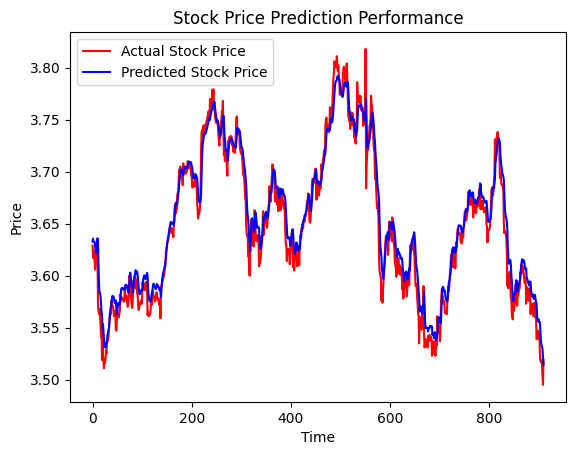

In [28]:
import matplotlib.pyplot as plt

actual_stock_price = test.iloc[:, 2:3].values

plt.plot(actual_stock_price, color = "red", label = "Actual Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Stock Price")
plt.title("Stock Price Prediction Performance")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()